# *svoboda lab / tactile navigation*

This notebook loads and plots the summary imaging data found in Sofroniew\*, Vlasov\*, et al. 2015 (to be submitted)

## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import json
from scipy import stats

## Setup plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from helper.plots import *

## Helper functions for loading and processing data

This helper function is using during loading to align tables to a primary key

In [3]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index,inplace = True)
    table.columns = table.columns.astype('float')
    return table

This helper function loads mutliple tables from a session into a dictionary where the keys are table names

In [4]:
def load(session, tables):
    # load the info
    with open(os.path.join(path,'data',session,'info.json')) as infile:
        info = json.load(infile)
        
    # load the units (which have our primary keys)
    units = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','units.csv'))
    
    # load all the tables
    d = {n : pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','%s.csv' % n)) for n in tables}
    
    # align the tables (specify each manually because different tables use different keys)
    d['waveforms'] = align(d['waveforms'], units, 'sourceId')
    d['profile'] = align(d['profile'], units, 'sourceId')
    xs, ys = smoothfit(d['profile'].columns.values, d['profile'].values[0],smooth=smooth, res=1000)
    smoothed = [smoothfit(d['profile'].columns.values, y, smooth=smooth,res=1000)[1] for y in d['profile'].values]
    d['profile'] = pd.DataFrame(smoothed, index=d['profile'].index, columns=xs)

    d['tuning'] = align(d['tuning'], units, ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarizeTuning(d['tuning'],-1)
    d['ISI'] = align(d['ISI'], units, 'sourceId')
    d['profileSummary'] = summarizeProfile(d['profile'])
    
    d['tuningSpeed'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-speed.csv'))
    d['tuningSpeed'] = align(d['tuningSpeed'], units, ['sourceId', 'label'])
    d['tuningSpeedNum'] = d['tuningSpeed'].xs('numTrials', level='label')
    err = d['tuningSpeed'].xs('stdRate', level='label').divide(d['tuningSpeedNum'].apply(np.sqrt))
    d['tuningSpeed'] = d['tuningSpeed'].xs('meanRate', level='label')
    d['tuningSpeedErr'] = err
    d['tuningSpeedSummary'] = summarizeTuning(d['tuningSpeed'],0)
    
    if info['clAnm']:
        d['tuningClosed'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-closed.csv'))
        d['tuningClosed'] = align(d['tuningClosed'], units, ['sourceId', 'label'])
        d['tuningClosedNum'] = d['tuningClosed'].xs('numTrials', level='label')
        err = d['tuningClosed'].xs('stdRate', level='label').divide(d['tuningClosedNum'].apply(np.sqrt))
        d['tuningClosed'] = d['tuningClosed'].xs('meanRate', level='label')
        d['tuningClosedErr'] = err
        d['tuningClosedSummary'] = summarizeTuning(d['tuningClosed'],-1)
    if info['ipsiAnm']:
        d['tuningIpsi'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-ipsi.csv'))
        d['tuningIpsi'] = align(d['tuningIpsi'], units, ['sourceId', 'label'])
        d['tuningIpsiNum'] = d['tuningIpsi'].xs('numTrials', level='label')
        err = d['tuningIpsi'].xs('stdRate', level='label').divide(d['tuningIpsiNum'].apply(np.sqrt))
        d['tuningIpsi'] = d['tuningIpsi'].xs('meanRate', level='label')
        d['tuningIpsiErr'] = err
        d['tuningIpsiSummary'] = summarizeTuning(d['tuningIpsi'],-1)
    if info['optoAnm']:
        d['tuningOpto'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-opto.csv'))
        d['tuningOpto'] = align(d['tuningOpto'], units, ['sourceId', 'label'])
        d['tuningOptoNum'] = d['tuningOpto'].xs('numTrials', level='label')
        err = d['tuningOpto'].xs('stdRate', level='label').divide(d['tuningOptoNum'].apply(np.sqrt))
        d['tuningOpto'] = d['tuningOpto'].xs('meanRate', level='label')
        d['tuningOptoErr'] = err
        d['tuningOptoSummary'] = summarizeTuning(d['tuningOpto'],-1)
    

    # assign the index
    units.set_index('sourceId',inplace = True)
    
    # classify units
    units['clean'] = classifyUnits(units)
    
    # add tables
    d['units'] = units
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    #d['info'] = info
    return d, info

#### Append position tuning information to units data frame

In [5]:
def summarizeTuning(df,index):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0],smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[index] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['ArgMin'] = [xs[np.argmin(y)] for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    
    #summary['ModulationOn'] = (summary.Max - summary.Baseline)/(summary.Baseline + summary.Max)
    #summary['ModulationOff'] = (summary.Min - summary.Baseline)/(summary.Baseline + summary.Min)
    #summary['Modulation'] = summary['ModulationOn']
    #summary['Modulation'][summary['Activation']<=summary['Supression']] = summary['ModulationOff'][summary['Activation']<=summary['Supression']]
    #summary['Simplicity'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    return summary

#### Append direction tuning information to units data frame

In [6]:
def summarizeProfile(df):
    x = df.columns.values
    summary = pd.DataFrame(index=df.index)
    summary['TowardsMod'] = [max(y[:500])-min(y[:500]) for y in df.values]
    summary['AwayMod'] = [max(y[-500:])-min(y[-500:]) for y in df.values]
    summary['Modulation'] = (summary.TowardsMod - summary.AwayMod)/(summary.TowardsMod + summary.AwayMod)

    summary['Max'] = [max(y) for y in df.values]
    summary['ArgMax'] = [x[np.argmax(y)] for y in df.values]
    summary['ArgMaxTowards'] = [x[np.argmax(y[:500])] for y in df.values]
    return summary

#### Classify units as clean or not

In [7]:
def classifyUnits(df):
    goodWaveformSNR = df.waveformSNR > 6
    goodISI = df.rateFA  < 1.5
    goodStability = (df.spkAmpDrift.abs() < 150) & (df.firingDrift.abs() < 175)
    clean = goodWaveformSNR & goodISI & goodStability
    return clean

#### Normalize spike waveforms

In [8]:
def normalize(waves):
    wavesNorm = [np.divide(x - np.mean(x),np.std(x)) for x in waves]
    return wavesNorm

#### Define smooth parameter

In [9]:
smooth = 1

## Create helper functions for plotting 

Define colors

In [10]:
fs = [.95, .63, .77]
frs = [.3, .3, .3]
rs = [.56, .45, .70]

## Load JSON + CSV as DataFrames

#### Specify location of the data

In [11]:
path = os.path.expanduser('~/Dropbox/paper.tuning')

#### Load the tables from each session

In [12]:
sessions = range(0,13)
tables = ['units', 'ISI', 'waveforms', 'tuning', 'profile']
data = [load('%02g' % s, tables) for s in sessions]
table =  pd.concat([x[0] for x in data], keys=[str(x[1].index[0]) for x in data], names=['anmId'])
info =  pd.concat([x[1] for x in data])

In [13]:
info

,animal,animal-state,barrel,clAnm,contributors,cordsAP,cordsML,experiment,id,ipsiAnm,lab,location,method,optoAnm,probe,region,session
Anm_0235585,Mouse,Awake head-fixed,C1,1,"Nicholas Sofroniew, Yurii Vlasov",-2.00,-3.525,Tactile Virtual Reality,Anm_0235585,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,00
Anm_0237723,Mouse,Awake head-fixed,C2,1,"Nicholas Sofroniew, Yurii Vlasov",-1.91,-3.600,Tactile Virtual Reality,Anm_0237723,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,01
Anm_0245918,Mouse,Awake head-fixed,D1,1,"Nicholas Sofroniew, Yurii Vlasov",-1.84,-3.400,Tactile Virtual Reality,Anm_0245918,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,02
Anm_0246702,Mouse,Awake head-fixed,D2,1,"Nicholas Sofroniew, Yurii Vlasov",-1.64,-3.340,Tactile Virtual Reality,Anm_0246702,1,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,03
Anm_0247871,Mouse,Awake head-fixed,C1,1,"Nicholas Sofroniew, Yurii Vlasov",-1.93,-3.470,Tactile Virtual Reality,Anm_0247871,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,04
Anm_0249872,Mouse,Awake head-fixed,C3,1,"Nicholas Sofroniew, Yurii Vlasov",-1.67,-3.650,Tactile Virtual Reality,Anm_0249872,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,05
Anm_0250492,Mouse,Awake head-fixed,C1,1,"Nicholas Sofroniew, Yurii Vlasov",-2.06,-3.630,Tactile Virtual Reality,Anm_0250492,1,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,06
Anm_0250494,Mouse,Awake head-fixed,B1,1,"Nicholas Sofroniew, Yurii Vlasov",-2.27,-3.600,Tactile Virtual Reality,Anm_0250494,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,07
Anm_0250495,Mouse,Awake head-fixed,C4,1,"Nicholas Sofroniew, Yurii Vlasov",-1.61,-3.780,Tactile Virtual Reality,Anm_0250495,1,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,08
Anm_0252776,Mouse,Awake head-fixed,C2,1,"Nicholas Sofroniew, Yurii Vlasov",-1.97,-3.600,Tactile Virtual Reality,Anm_0252776,0,Svoboda Lab,Janelia Research Campus,Silcon probe electrophysiology,0,A32-edge,vS1,09


## Plot location of recordings

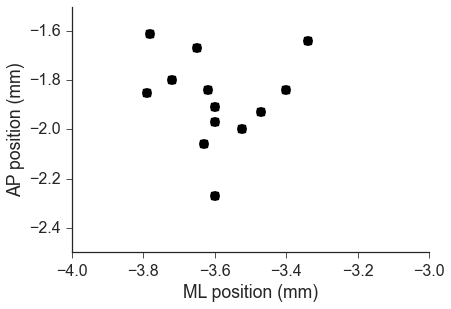

In [14]:
plt.plot(info.cordsML,info.cordsAP,'.', color='k', ms=20);
plt.ylim([-2.5, -1.5])
plt.xlim([-4.0, -3.0])
plt.xlabel('ML position (mm)')
plt.ylabel('AP position (mm)')
sns.despine()

## Summarize units

#### Plot waveform SNR vs False Alarm Rate

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sofroniewn/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


(0, 3)

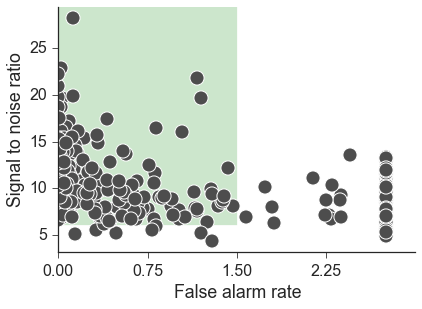

In [15]:
x = table.units.rateFA
x[x>2.5] = 2.75;
y = table.units.waveformSNR
scatter(x, y, xlabel='False alarm rate', ylabel='Signal to noise ratio');
plt.xticks(np.linspace(0,2.25,4));
#plt.plot([1.5, 1.5], [6, 30], color=[0,0.6,0], zorder=1)
#plt.plot([0, 1.5], [6, 6], color=[0,0.6,0], zorder=1)
plt.fill([0, 1.5, 1.5, 0], [6, 6, 30, 30], edgecolor=[0.8,0.9,0.8], facecolor=[0.8,0.9,0.8]);
plt.xlim([0, 3]);
#plt.savefig(os.path.join(path,'figuresEphys','SpikeQualityCol.eps'))


#### Take only clean units

In [16]:
table = table[table.units.clean]
print len(table)

209


In [17]:
goodTuning = table.units.pVal < 0.05
table = table[goodTuning]

#### Summarize clean units

In [18]:
units = table.units.reset_index()
print len(units)
unitCount = units.groupby(['anmId']).count()['sourceId'].values
print np.mean(unitCount), np.std(unitCount), len(unitCount)

179
13.7692307692 6.22839460923 13


## Plot spike summary information

#### Plot example mean waveform

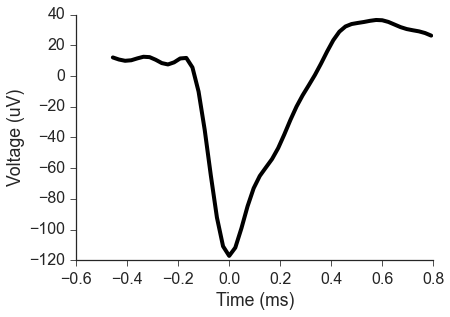

In [19]:
a = 'Anm_0235585'
u = 9
x = table.waveforms.columns
y = table.waveforms.loc[a,u].values
time(x, y)
plt.xlabel('Time (ms)');
plt.ylabel('Voltage (uV)');

#### Plot distribution of spike widths

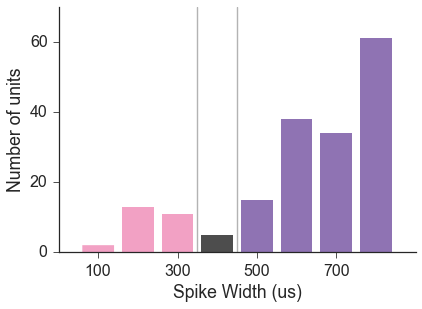

In [20]:
bins=range(50,950,100)
out = plt.hist(table.units.spkWidth, bins=bins, rwidth=0.8, color=[0.7,0.7,0.7], edgecolor='none');
plt.xlabel('Spike Width (us)')
plt.ylabel('Number of units')
col = [fs,fs,fs,frs,rs,rs,rs,rs]
for c, p in zip(col, out[2]):
    plt.setp(p, 'facecolor', c)
plt.plot([350, 350], [0, 70], color=[0.7,0.7,0.7], zorder=1)
plt.plot([450, 450], [0, 70], color=[0.7,0.7,0.7], zorder=1)
plt.ylim([0, 70])
plt.yticks(range(0,65,20))
plt.xticks(range(100,800,200))
sns.despine()

#### Plot waveforms across cell types

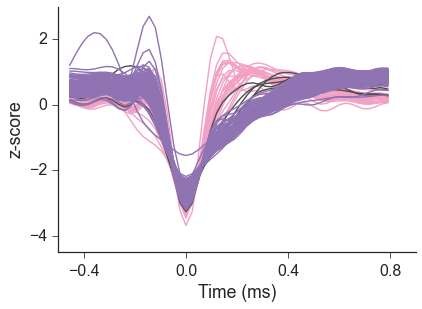

In [21]:
waves = table.waveforms[table.units.cellType == 'FastSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = fs);
waves = table.waveforms[table.units.cellType == 'IntermediateSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = frs);
waves = table.waveforms[table.units.cellType == 'RegularSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = rs);
sns.despine()
plt.xlabel('Time (ms)');
plt.ylabel('z-score');
plt.yticks(range(-4,3,2))
plt.ylim([-4.5, 3])
plt.xticks(np.linspace(-0.4,.8,4))
plt.xlim([-.5, .9]);

#### Plot example ISI

The paper includes the following ISI plots
* 'Anm_0235585', 9
* 'Anm_0250492', 28
* 'Anm_0256043', 0
* 'Anm_0237723', 0
* 'Anm_0237723', 27
* 'Anm_0250492', 0
* 'Anm_0250495', 8
* 'Anm_0235585', 12
* 'Anm_0245918', 15
* 'Anm_0237723', 2
* 'Anm_0235585', 2
* 'Anm_0245918', 2

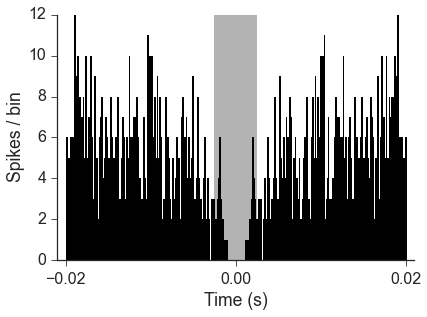

In [22]:
a = 'Anm_0235585'
u = 9
x = table.ISI.columns
y = table.ISI.loc[a, u]
plt.bar(-.0025, max(y), width=.005, linewidth=0, color=[.7, .7, .7]);
plt.bar(x, y, width=.0002, linewidth=0, color='k');
plt.xticks(np.linspace(-.02,.02,3))
plt.xlim([-.021, 0.021])
plt.xlabel('Time (s)');
plt.ylabel('Spikes / bin');
sns.despine()

## Extract units for tuning analysis

In [23]:
tableFS = table[table.units.cellType == 'FastSpiker']
table = table[table.units.cellType == 'RegularSpiker']
print len(table)

148


#FIGURE 3

## Plot tuning curves

The paper includes the following tuning curves
* 'Anm_0235585', 9
* 'Anm_0250492', 28
* 'Anm_0256043', 0
* 'Anm_0237723', 0
* 'Anm_0237723', 27
* 'Anm_0250492', 0
* 'Anm_0250495', 8
* 'Anm_0256043', 0
* 'Anm_0256043', 10

-0.32


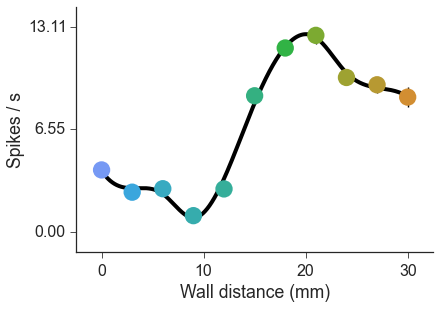

In [24]:
a = 'Anm_0256043'
u = 0
x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
rng = tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');
print '%.2f' % table.tuningSummary.Modulation.loc[a,u]
#plt.savefig(os.path.join(path,'figuresEphys','Tuning%s_%s.eps' % (a, u)))

#### Plot fast spiking neurons

The paper includes the following tuning curves
* 'Anm_0250492', 14
* 'Anm_0270330', 1
* 'Anm_0237723', 4

0.85


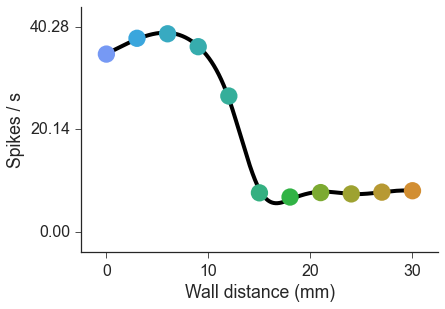

In [25]:
a = 'Anm_0237723'
u = 4
x = tableFS.tuning.columns.values
y = tableFS.tuning.loc[a,u].values
err = tableFS.tuningErr.loc[a,u].values
rng = tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');
print '%.2f' % tableFS.tuningSummary.Modulation.loc[a,u]
#plt.yticks([0, 20, 40])
#plt.savefig(os.path.join(path,'figuresEphys','FSTuning%s_%s.eps' % (a, u)))

####Plot ipsi tuning curve

The paper includes the following ipsilateral tuning curves
* 'Anm_0250492', 0
* 'Anm_0250495', 8

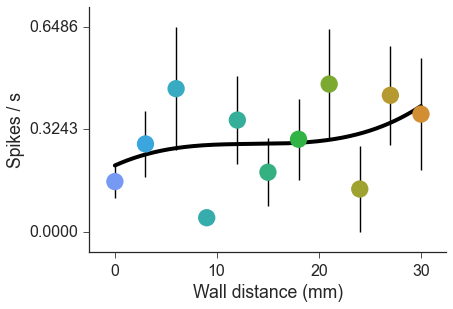

In [26]:
a = 'Anm_0250492'
u = 0    
x = table.tuningIpsi.columns.values
y = table.tuningIpsi.loc[a,u].values
err = table.tuningIpsiErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');

####Plot closed-loop tuning curve

The paper includes the following closed-loop tuning curves
* 'Anm_0250492', 0
* 'Anm_0250495', 8

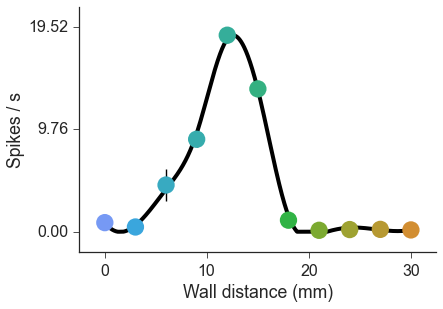

In [27]:
a = 'Anm_0250492'
u = 0
x = table.tuningClosed.columns.values[:11]
y = table.tuningClosed.loc[a,u].values[:11]
err = table.tuningClosedErr.loc[a,u].values[:11]
tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');

####Plot opto tuning curves

The paper includes the following closed-loop tuning curves
* 'Anm_0256043', 10
* 'Anm_0256043', 0

1.00


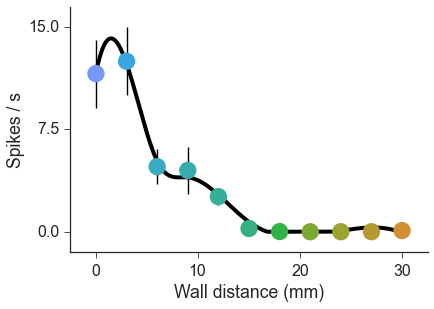

In [28]:
a = 'Anm_0256043'
u = 10
x = table.tuningOpto.columns.values
y = table.tuningOpto.loc[a,u].values
err = table.tuningOptoErr.loc[a,u].values
rng = tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');
print '%.2f' % table.tuningOptoSummary.Modulation.loc[a,u]
#plt.savefig(os.path.join(path,'figuresEphys','TuningOpto%s_%s.eps' % (a, u)))

####Plot speed tuning curves

The paper includes the following closed-loop tuning curves
* 'Anm_0245918', 4
* 'Anm_0235585', 10
* 'Anm_0235585', 27
* 'Anm_0245918', 9

1.00


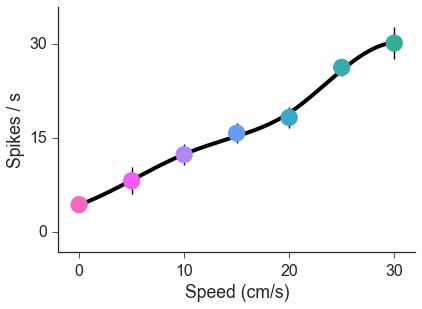

In [29]:
a = 'Anm_0245918'
u = 4
x = table.tuningSpeed.columns.values
y = table.tuningSpeed.loc[a,u].values
err = table.tuningSpeedErr.loc[a,u].values
x = x[~np.isnan(y)]
err = err[~np.isnan(y)]
y = y[~np.isnan(y)]
pal = sns.color_palette("husl", n_colors=len(x) + 6)
pal = pal[6:6+len(x)][::-1]
rng = tuning(x, y, err, smooth=smooth, pal=pal, ylabel='Spikes / s', label = 'Speed (cm/s)');
print '%.2f' % table.tuningSpeedSummary.Modulation.loc[a,u]
plt.xlim([-2, 32]);
plt.yticks([0, 15, 30]);
plt.savefig(os.path.join(path,'figuresEphys','TuningSpeed%s_%s.eps' % (a, u)))

### Plot scatter of supression vs activation

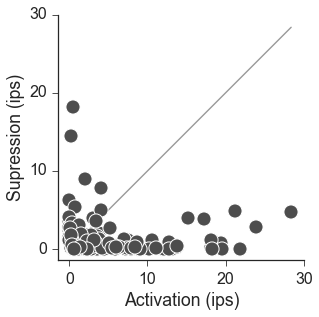

In [99]:
x = table.tuningSummary.Activation
y = table.tuningSummary.Supression
scatter(x, y, equal=True, xlabel='Activation (ips)', ylabel='Supression (ips)')
plt.yticks([0, 10, 20, 30]);
plt.xticks([0, 10, 20, 30]);

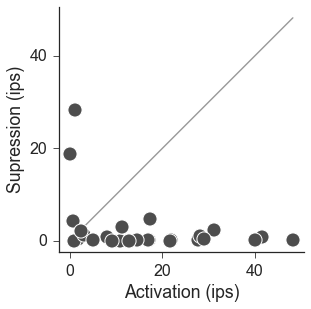

In [114]:
x = tableFS.tuningSummary.Activation
y = tableFS.tuningSummary.Supression
scatter(x, y, equal=True, xlabel='Activation (ips)', ylabel='Supression (ips)')
plt.yticks([0, 20, 40]);
plt.xticks([0, 20, 40]);
#plt.savefig(os.path.join(path,'figuresEphys','FSActSup.eps'))

### Plot summary tuning curves

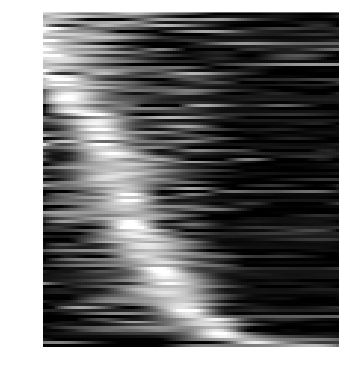

In [98]:
curves = table.sort([('tuningSummary','ArgMax')])
curves = curves[curves.tuningSummary.Activation>1]
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=0, res=100)
fits = stats.zscore(fits, axis=1)
heatmap(fits, aspect=1, vmin=-1, vmax=2.5)
#plt.savefig(os.path.join(path,'Tuning%s_units.eps' % len(fits)))

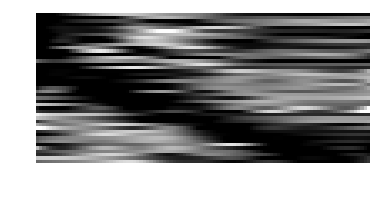

In [74]:
curves = table.sort([('tuningSummary','ArgMin')])
curves = curves[curves.tuningSummary.Supression>1]
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=0, res=100)
fits = stats.zscore(fits, axis=1)
heatmap(fits, aspect=1, vmin=-1, vmax=2.5)
plt.savefig(os.path.join(path,'TuningOff%s_units.eps' % len(fits)))

### Plot histogram of modulation

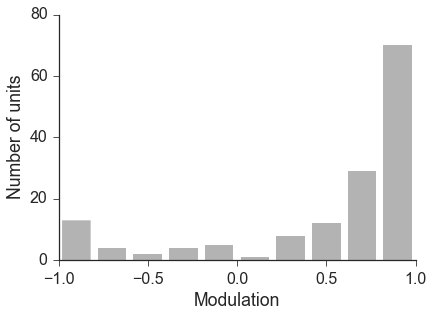

In [75]:
hist(table.tuningSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(np.linspace(0,80,5));

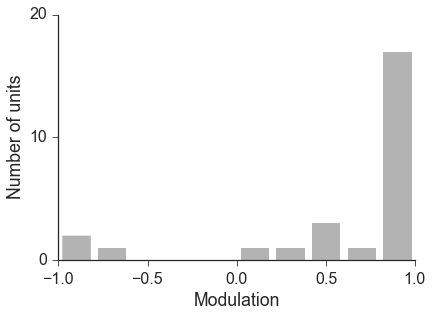

In [113]:
hist(tableFS.tuningSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(np.linspace(0,20,3));
#plt.savefig(os.path.join(path,'figuresEphys','FSMod.eps'))

### Plot histogram of modulation

([<matplotlib.axis.XTick at 0x110444e90>,
 <a list of 4 Text xticklabel objects>)

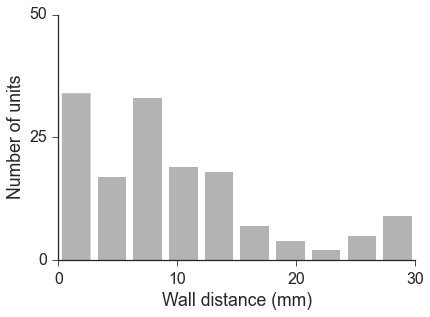

In [76]:
hist(table.tuningSummary.ArgMax, xlabel='Wall distance (mm)', ylabel='Number of units')
plt.yticks(np.linspace(0,50,3));
plt.xticks(np.linspace(0,30,4));
#plt.savefig(os.path.join(path,'figuresEphys','ArgMax.eps'))

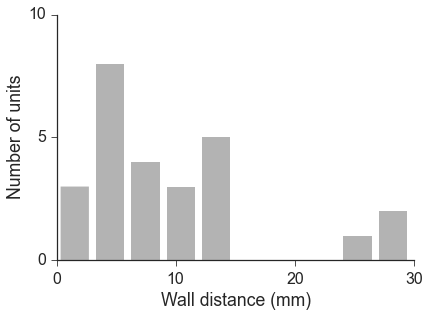

In [112]:
hist(tableFS.tuningSummary.ArgMax, xlabel='Wall distance (mm)', ylabel='Number of units')
plt.yticks(np.linspace(0,10,3));
plt.xticks(np.linspace(0,30,4));
#plt.savefig(os.path.join(path,'figuresEphys','FSArgMax.eps'))

### Plot scatter of wall modulation across layer 4 distance

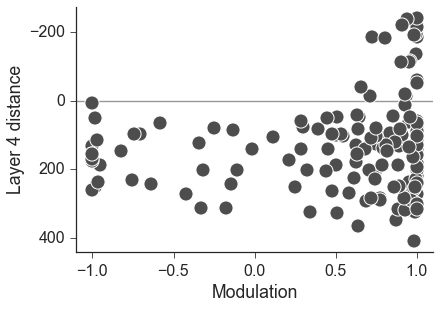

In [77]:
x = table.tuningSummary.Modulation
y = table.units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4));
plt.plot([-1.1, 1.1], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);

#### Plot scatter of wall out of reach activity across layer 4 distance

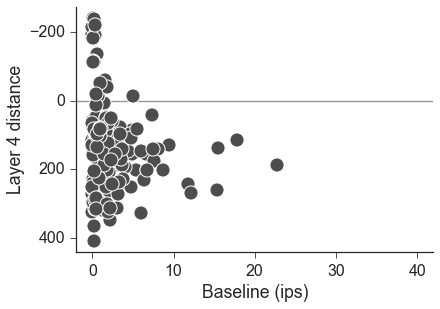

In [78]:
x = table.tuningSummary.Baseline
y = table.units.distLayer4
scatter(x, y, yinvert=True, xlabel='Baseline (ips)', ylabel='Layer 4 distance')
plt.plot([-2, 42], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);
plt.xlim([-2, 42])
plt.yticks(np.linspace(-200,400,4));

#### Plot scatter of peak wall distance activity across layer 4 distance

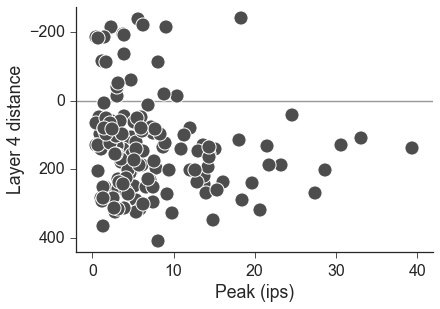

In [79]:
x = table.tuningSummary.Max
y = table.units.distLayer4
scatter(x, y, xlabel='Peak (ips)', ylabel='Layer 4 distance', yinvert=True)
plt.xlim([-2, 42])
plt.plot([-2, 42], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);
plt.yticks(np.linspace(-200,400,4));

## Plot profiles

The paper includes the following time profiles
* 'Anm_0235585', 12
* 'Anm_0245918', 15
* 'Anm_0237723', 2
* 'Anm_0235585', 2

0.28


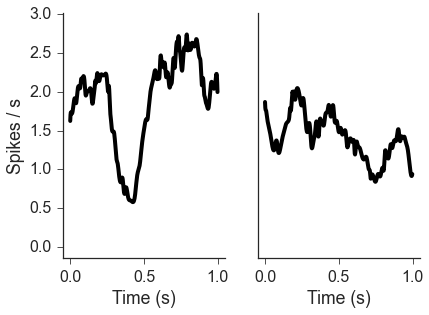

In [80]:
a = 'Anm_0237723'
u = 2
x1 = table.profile.columns.values[:500]
x1 = x1 - x1[0]
y1 = table.profile.loc[a, u].values[:500]
x2 = table.profile.columns.values[500:]
x2 = x2 - x2[0]
y2 = table.profile.loc[a, u].values[500:]
pairedtime(x1, y1, x2, y2);
print '%.2f' % table.profileSummary.Modulation.loc[a,u]

##Plot heatmap profiles

#### Plot symmetric units

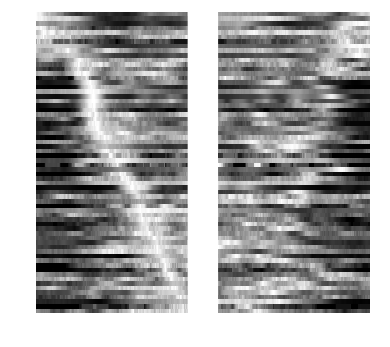

In [81]:
curves = table.sort([('profileSummary','ArgMaxTowards')])
curves = curves[curves.profileSummary.Modulation.abs()<=0.2]
vals1 = np.asarray([x[:500] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
vals2 = np.asarray([x[500:] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
pairedheatmap(vals1, vals2, aspect=15)

#### Plot asymmetric units

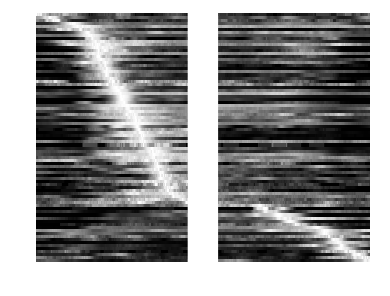

In [82]:
curves = table.sort([('profileSummary','ArgMax')])
curves = curves[curves.profileSummary.Modulation.abs()>0.2]
vals1 = np.asarray([x[:500] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
vals2 = np.asarray([x[500:] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
pairedheatmap(vals1, vals2, aspect=10)

##Plot summary data

#### Plot scatter of supression vs activation

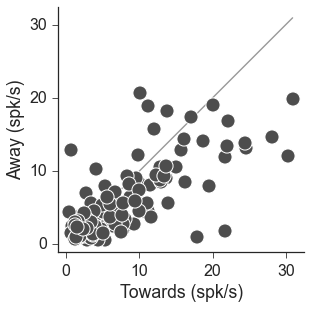

In [83]:
x = table.profileSummary.TowardsMod
y = table.profileSummary.AwayMod
scatter(x, y, equal=True, xlabel='Towards (spk/s)', ylabel='Away (spk/s)')
plt.yticks([0, 10, 20, 30]);
plt.xticks([0, 10, 20, 30]);

#### Plot histogram of modulation

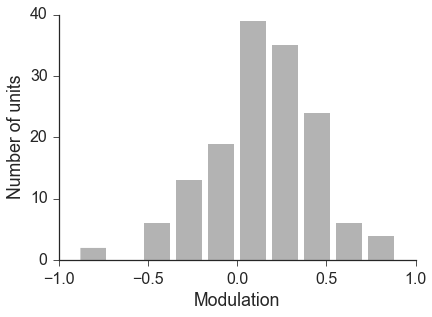

In [84]:
hist(table.profileSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(range(0,50,10));

#### Plot scatter of wall modulation across layer 4 distance

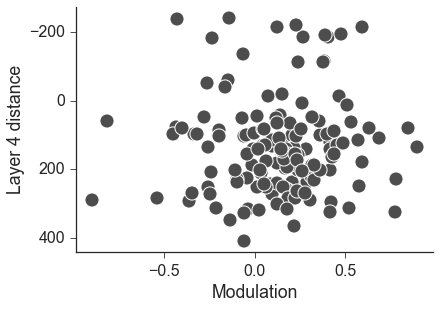

In [85]:
x = table.profileSummary.Modulation
y = table.units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4));

### Ipsi vs contra summary

0.979808875864
0.835777827219


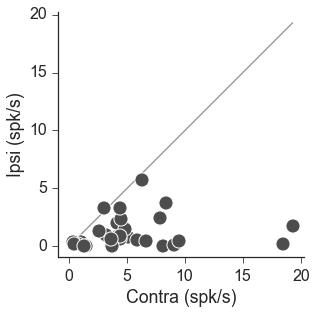

In [86]:
x = table[~table.units.pValIpsi.isnull()].tuningSummary.Range
y = table[~table.units.pValIpsi.isnull()].tuningIpsiSummary.Range
modLat = np.divide(x-y,x+y)
print modLat['Anm_0250492', 0]
print modLat['Anm_0250492', 8]
scatter(x, y, equal=True, xlabel='Contra (spk/s)', ylabel='Ipsi (spk/s)')

#### Histogram of ipsi vs contra modulation

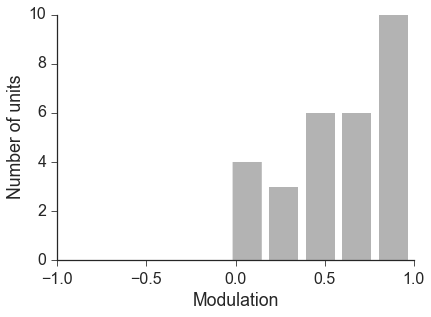

In [87]:
hist(modLat, bins=5, xlabel='Modulation', ylabel='Number of units')
plt.xlim([-1, 1]);

### Open loop vs closed loop summary

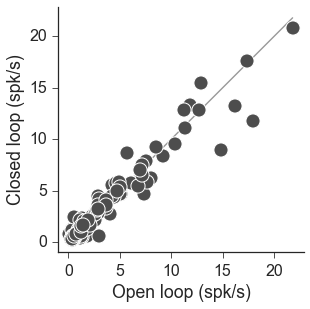

In [88]:
frac = table[~table.units.pValClosed.isnull()].tuningClosedNum.divide(table.tuningClosedNum.sum(axis=1),axis=0)<.02
vals = table[~table.units.pValClosed.isnull()].tuningClosed.values
vals = vals[:,:11]
frac = frac.values[:,:11]
vals[frac] = np.nan
x = np.nanmean(vals, axis=1)
vals = table[~table.units.pValClosed.isnull()].tuning.values
vals[frac] = np.nan
y = np.nanmean(vals, axis=1)
modLoop = np.divide(x-y,x+y)
scatter(x, y, equal=True, xlabel='Open loop (spk/s)', ylabel='Closed loop (spk/s)')

####Histogram of open vs closed loop modulation

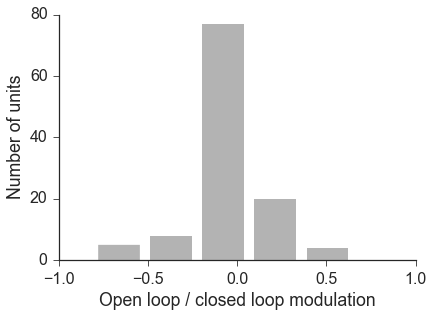

In [89]:
hist(modLoop, bins=5, xlabel='Open loop / closed loop modulation', ylabel='Number of units')
plt.xlim([-1, 1]);
plt.yticks(range(0,100,20));

### Depth of units recorded

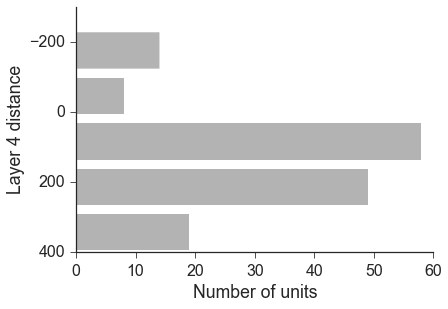

In [90]:
vals = table.units.distLayer4
hist(vals, bins=5, horizontal=True, xlabel='Number of units', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4));

## Opto tuning

11
24


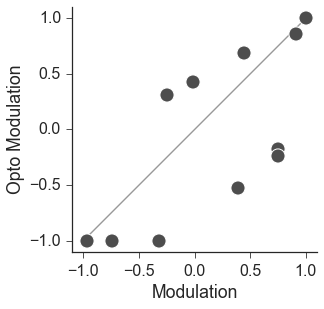

In [91]:
x = table[table.units.pValOpto < .05].tuningSummary.Modulation
y = table[table.units.pValOpto < .05].tuningOptoSummary.Modulation
scatter(x, y, xlabel='Modulation', ylabel='Opto Modulation', yinvert=False, equal=True)
#plt.savefig(os.path.join(path,'figuresEphys','OptoWall.eps'))
stats.linregress(x, y)
print sum(table.units.pValOpto < .05)
print sum(table.units.pValOpto < 10)

([<matplotlib.axis.YTick at 0x10f597e90>,
 <a list of 4 Text yticklabel objects>)

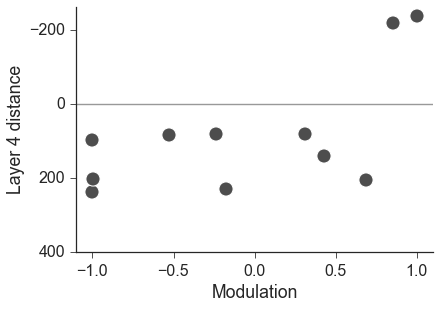

In [92]:
x = table[table.units.pValOpto < .05].tuningOptoSummary.Modulation
y = table[table.units.pValOpto < .05].units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True);
plt.plot([-1.1, 1.1], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);
plt.yticks(np.linspace(-200,400,4));
#plt.savefig(os.path.join(path,'figuresEphys','OptoDepth.eps'))

## Speed tuning

([<matplotlib.axis.YTick at 0x110a8a790>,
 <a list of 4 Text yticklabel objects>)

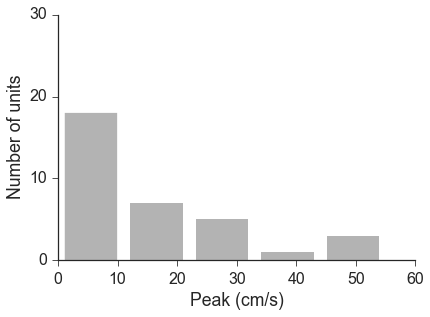

In [30]:
x = table[(table.units.pValSpeed < .05) & (table.tuningSpeedSummary.Range > 1)].tuningSpeedSummary.ArgMax
hist(x, bins=5, xlabel='Peak (cm/s)', ylabel='Number of units')
plt.yticks(range(0,40,10));
#plt.savefig(os.path.join(path,'figuresEphys','SpeedHist.eps'))

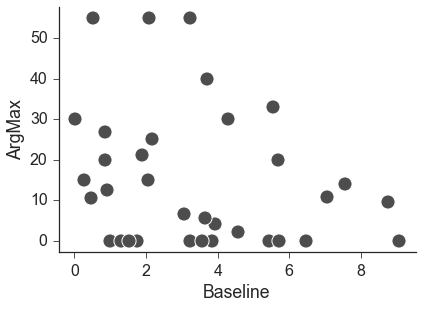

In [94]:
x = table[(table.units.pValSpeed < .05) & (table.tuningSpeedSummary.Range > 1)].tuningSpeedSummary.Baseline
y = table[(table.units.pValSpeed < .05) & (table.tuningSpeedSummary.Range > 1)].tuningSpeedSummary.ArgMax
scatter(x, y, xlabel='Baseline', ylabel='ArgMax');

In [32]:
print len(table)
print sum(table.units.pValSpeed < .05)
print sum(table.units.pValSpeed < .05).astype('float64')/len(table)

148
46
0.310810810811


In [33]:
46.0/114

0.40350877192982454